In [5]:
import pickle
import operator
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from keras_contrib.utils import save_load_utils

from keras import layers
from keras import optimizers

from keras.models import Model
from keras.models import Input

from keras_contrib.layers import CRF
from keras_contrib import losses
from keras_contrib import metrics

Using TensorFlow backend.


In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
pip install keras==2.2.4

In [3]:
pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-_leq68lk
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-_leq68lk


In [4]:
from google.colab import files
uploaded=files.upload()

Saving FinalDataset4.xlsx to FinalDataset4.xlsx


In [6]:
data_df = pd.read_excel("FinalDataset4.xlsx")
data_df.head()

,Unnamed: 0,index,Sentence #,Word,Tags,POS
0,0,7,1,Ovarian,O,JJ
1,0,7,1,cancer,O,NN
2,0,7,1,highly,O,RB
3,0,7,1,sensitive,O,JJ
4,0,7,1,chemotherapy,O,NN


In [8]:
print("Total number of sentences in the dataset: {:,}".format(data_df["Sentence #"].nunique()))
print("Total words in the dataset: {:,}".format(data_df.shape[0]))

Total number of sentences in the dataset: 789
Total words in the dataset: 13,413


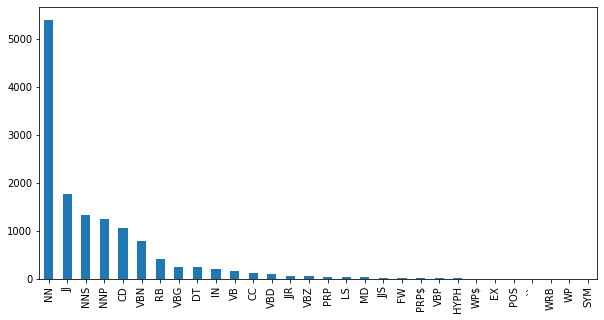

In [9]:
data_df["POS"].value_counts().plot(kind="bar", figsize=(10,5));

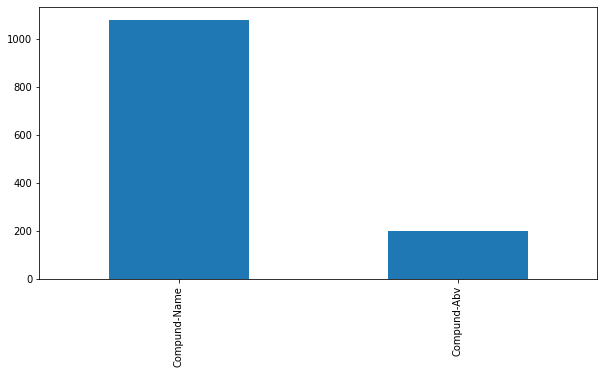

In [10]:
data_df[data_df["Tags"]!="O"]["Tags"].value_counts().plot(kind="bar", figsize=(10,5))

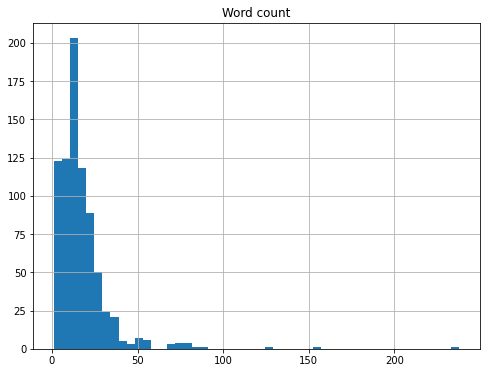

In [11]:
word_counts = data_df.groupby("Sentence #")["Word"].agg(["count"])
word_counts = word_counts.rename(columns={"count": "Word count"})
word_counts.hist(bins=50, figsize=(8,6));

In [12]:
MAX_SENTENCE = word_counts.max()[0]
print("Longest sentence in the corpus contains {} words.".format(MAX_SENTENCE))

Longest sentence in the corpus contains 238 words.


In [13]:
longest_sentence_id =word_counts[word_counts["Word count"]==MAX_SENTENCE].index[0]
print("ID of the longest sentence is {}.".format(longest_sentence_id))

ID of the longest sentence is 287.


In [14]:
longest_sentence = data_df[data_df["Sentence #"]==longest_sentence_id]["Word"].str.cat(sep=' ')
print("The longest sentence in the corpus is:\n")
print(longest_sentence)

The longest sentence in the corpus is:

html Treating Ovarian Cancer Local treatments Systemic treatments Common approaches Who treats ovarian cancer Making treatment decisions Thinking taking part clinical trial Considering complementary alternative methods Help getting cancer treatment Choosing stop treatment choosing treatment ￼Surgery Ovarian Cancer Surgery epithelial ovarian cancer Staging epithelial ovarian cancer Debulking epithelial ovarian cancer Surgery ovarian germ cell tumors ovarian stromal tumors More information Surgery Hyperlinks References ￼Chemotherapy Ovarian Cancer Chemotherapy epithelial ovarian cancer Intraperitoneal IP chemotherapy Chemotherapy germ cell tumors Chemotherapy stromal tumors Side effects chemotherapy More information chemotherapy Hyperlinks References ￼Targeted Therapy Ovarian Cancer Bevacizumab Side effects bevacizumab PARP inhibitors Side effects PARP inhibitors Drugs target cells NTRK gene changes Side effects drugs target NTRK gene changes More 

In [15]:
all_words = list(set(data_df["Word"].values))
all_tags = list(set(data_df["Tags"].values))
print("Number of unique words: {}".format(data_df["Word"].nunique()))
print("Number of unique tags : {}".format(data_df["Tags"].nunique()))

Number of unique words: 3822
Number of unique tags : 3


In [16]:
word2index = {word: idx + 2 for idx, word in enumerate(all_words)}
word2index["--UNKNOWN_WORD--"]=0
word2index["--PADDING--"]=1
index2word = {idx: word for word, idx in word2index.items()}

In [17]:
for k,v in sorted(word2index.items(), key=operator.itemgetter(1))[:10]:
    print(k,v)

--UNKNOWN_WORD-- 0
--PADDING-- 1
showing 2
distinctive 3
Arsenic 4
combination 5
including 6
soravtansine 7
Li 8
BRCA1 9


In [18]:
test_word = "cisplatin"
test_word_idx = word2index[test_word]
test_word_lookup = index2word[test_word_idx]

print("The index of the word {} is {}.".format(test_word, test_word_idx))
print("The word with index {} is {}.".format(test_word_idx, test_word_lookup))

The index of the word cisplatin is 3010.
The word with index 3010 is cisplatin.


In [19]:
tag2index = {tag: idx + 1 for idx, tag in enumerate(all_tags)}
tag2index["--PADDING--"] = 0
index2tag = {idx: word for word, idx in tag2index.items()}

In [20]:
def to_tuples(data):
    iterator = zip(data["Word"].values.tolist(),
                   data["POS"].values.tolist(),
                   data["Tags"].values.tolist())
    return [(word, pos, tag) for word, pos, tag in iterator]

sentences = data_df.groupby("Sentence #").apply(to_tuples).tolist()

sentences[0]

[('Ovarian', 'JJ', 'O'),
 ('cancer', 'NN', 'O'),
 ('highly', 'RB', 'O'),
 ('sensitive', 'JJ', 'O'),
 ('chemotherapy', 'NN', 'O'),
 ('drugs', 'NNS', 'O'),
 ('particularly', 'RB', 'O'),
 ('platinum', 'NN', 'Compund-Name'),
 ('agents', 'NNS', 'O'),
 ('patients', 'NNS', 'O'),
 ('attain', 'VB', 'O'),
 ('remission', 'NN', 'O'),
 ('initial', 'JJ', 'O'),
 ('treatment', 'NN', 'O')]

In [21]:
X = [[word[0] for word in sentence] for sentence in sentences]
y = [[word[2] for word in sentence] for sentence in sentences]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: ['Ovarian', 'cancer', 'highly', 'sensitive', 'chemotherapy', 'drugs', 'particularly', 'platinum', 'agents', 'patients', 'attain', 'remission', 'initial', 'treatment']
y[0]: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'Compund-Name', 'O', 'O', 'O', 'O', 'O', 'O']


In [22]:
X = [[word2index[word] for word in sentence] for sentence in X]
y = [[tag2index[tag] for tag in sentence] for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [3670, 2011, 1904, 2076, 1667, 3808, 2956, 2625, 1420, 617, 2865, 198, 1799, 1723]
y[0]: [2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2]


In [23]:
X = [sentence + [word2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in X]
y = [sentence + [tag2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [3670, 2011, 1904, 2076, 1667, 3808, 2956, 2625, 1420, 617, 2865, 198, 1799, 1723, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y[0]: [2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [24]:
TAG_COUNT = len(tag2index)
y = [ np.eye(TAG_COUNT)[sentence] for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [3670, 2011, 1904, 2076, 1667, 3808, 2956, 2625, 1420, 617, 2865, 198, 1799, 1723, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y[0]: [[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)
print("Number of sentences in the training dataset: {}".format(len(X_train)))
print("Number of sentences in the test dataset : {}".format(len(X_test)))

Number of sentences in the training dataset: 710
Number of sentences in the test dataset : 79


In [26]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [27]:
WORD_COUNT = len(index2word)
DENSE_EMBEDDING = 20
LSTM_UNITS = 20
LSTM_DROPOUT = 0.1
DENSE_UNITS = 50
BATCH_SIZE = 128
MAX_EPOCHS = 5

In [28]:
input_layer = layers.Input(shape=(MAX_SENTENCE,))
model = layers.Embedding(WORD_COUNT, DENSE_EMBEDDING, embeddings_initializer="uniform", input_length=MAX_SENTENCE)(input_layer)
model = layers.Bidirectional(layers.LSTM(LSTM_UNITS, recurrent_dropout=LSTM_DROPOUT, return_sequences=True))(model)
model = layers.TimeDistributed(layers.Dense(DENSE_UNITS, activation="relu"))(model)
crf_layer = CRF(units=TAG_COUNT)
output_layer = crf_layer(model)

ner_model = Model(input_layer, output_layer)

loss = losses.crf_loss
acc_metric = metrics.crf_accuracy
#opt = optimizers.Adam(lr=0.001)

ner_model.compile(optimizer="adam", loss=loss, metrics=[acc_metric])

ner_model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 238)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 238, 20)           76480     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 238, 40)           6560      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 238, 50)           2050      
_________________________________________________________________
crf_1 (CRF)                  (None, 238, 4)            228       
Total params: 85,318
Trainable params: 85,318
Non-trainable 

In [29]:
history = ner_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=MAX_EPOCHS, validation_split=0.1, verbose=2)




Train on 639 samples, validate on 71 samples
Epoch 1/5





 - 4s - loss: 1.3660 - crf_accuracy: 0.0091 - val_loss: 1.3084 - val_crf_accuracy: 0.0098
Epoch 2/5
 - 2s - loss: 1.2646 - crf_accuracy: 0.0091 - val_loss: 1.1896 - val_crf_accuracy: 0.0098
Epoch 3/5
 - 2s - loss: 1.1248 - crf_accuracy: 0.0807 - val_loss: 1.0174 - val_crf_accuracy: 0.8799
Epoch 4/5
 - 2s - loss: 0.9218 - crf_accuracy: 0.9142 - val_loss: 0.7597 - val_crf_accuracy: 0.9393
Epoch 5/5
 - 2s - loss: 0.6252 - crf_accuracy: 0.9353 - val_loss: 0.4211 - val_crf_accuracy: 0.9310


In [30]:
pip install plot_keras_history

In [31]:
from  plot_keras_history import plot_history

(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa65780ce10>,
       dtype=object))

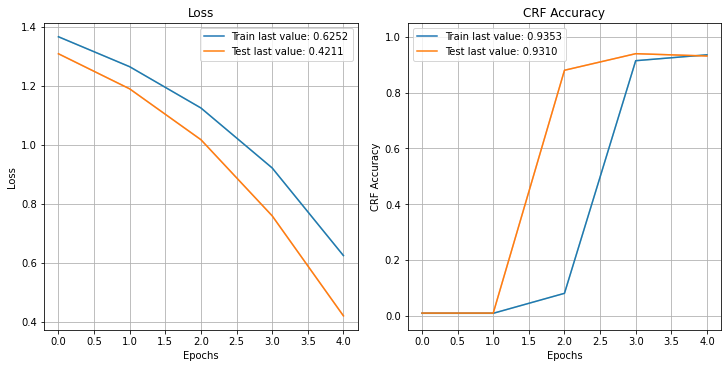

In [32]:
plot_history(history.history)

In [33]:
y_pred = ner_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=2)
y_test = np.argmax(y_test, axis=2)

accuracy = (y_pred == y_test).mean()

print("Accuracy: {:.4f}\n".format(accuracy))

Accuracy: 0.9402



In [34]:
from sklearn.metrics import f1_score,precision_score,recall_score,classification_report

In [35]:
classification_report(y_test.flatten(),y_pred.flatten())

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           0       0.94      1.00      0.97     17629\n           1       0.00      0.00      0.00        99\n           2       0.86      0.05      0.09      1052\n           3       0.00      0.00      0.00        22\n\n    accuracy                           0.94     18802\n   macro avg       0.45      0.26      0.26     18802\nweighted avg       0.93      0.94      0.91     18802\n'

In [36]:
precision_score(y_test.flatten(),y_pred.flatten(),average="weighted")

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9300782662086302

In [37]:
recall_score(y_test.flatten(),y_pred.flatten(),average="weighted")

0.9402191256249335

In [38]:
f1_score(y_test.flatten(),y_pred.flatten(),average="weighted")

0.9138901465186229